In this notebook, we want to summarize the data and make sure that it is behaving as we expect based on previous literature. Here, we want to only use the outcome for tumor_cell_evaluation
    
Tumor score is defined by UCSF pathologists in the following way: <br>

0: neuropil without tumor <br>
1: infiltrating tumor margin containing a detectable but not abundant number of tumor cells <br>
2: more cellular infiltrated zone <br>
3: highly cellular tumor <br>

In [1]:
recgli = read.csv("../../ParseData/8thParse_researchPath_withInVivo.csv") 
dim(recgli)

[1] 391  74

In [2]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

#### In this notebook, we want to find: <br>
1. perfusion params vs. TS using <br>
    a. No separation into ROIs <br>
    b. Visual comparison of perfusion params in separate regions <br>
    c. Use GLMM associate perfusion parameters with TS, no separation <br>
    d. Use GEE to associate perfusion parameters with TS, no separation <br>
    e. Use RM ANOVA to try to associate outcome w/ imaging params (not other way around!) <br>
    f. Use GLMM to associate perfusion parameters with TS, separating into CEL & NEL <br>
    g. Use GEE to associate perfusion parameters with TS, separating into CEL & NEL <br>
    
2. Combining perf params vs. TS using GEE 
3. Using in_CEL as a covariate in perf params using GEE 

## 0. Prep the data

In [3]:
recgli = recgli[recgli$tumor_cell_evaluation != "Ind",]
dim(recgli)
recgli = droplevels(recgli)
recgli$tumor_cell_evaluation = as.character(recgli$tumor_cell_evaluation)
recgli$tumor_cell_evaluation = as.numeric(recgli$tumor_cell_evaluation)
str(recgli$tumor_cell_evaluation)
colnames(recgli)

[1] 383  74

 num [1:383] 0 2 2 2 0 1 0 2 1 0 ...


[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "f8_delicate"               "f8_simple"                
[13] "f8_complex"                "mib_1"                    
[15] "bx_pure_treatment_effect"  "nfse"                     
[17] "nfl"                       "nt1c"                     
[19] "nt1v"                      "nadc.1"                   
[21] "nfa.1"                     "nev1.1"                   
[23] "nev2.1"                    "nev3.1"                   
[25] "nevrad.1"                  "nadc.2"                   
[27] "nfa.2"                     "nev1.2"                   
[29] "nev2.2"                    "nev3.2"                   
[31] "nevrad.2"                  "cbvn_nlin"                
[33] "phn_nlin"                  "phn_npar"                 
[35] "recovn_npar"               "cni"                      
[37] "ccri"                      "crni"                     
[39] "ncho"                      "ncre"                     
[41] "nnaa"                      "nlip"                     
[43] "laclip"                    "nlac"                     
[45] "olddata"                   "newdata"                  
[47] "comments"                  "notes."                   
[49] "imaging_code"              "perf_quant"               
[51] "cbv_nlin"                  "spec_quant"               
[53] "include_anat"              "include_diffu1000"        
[55] "include_diffu2000"         "include_diffu_all"        
[57] "include_perf"              "include_spec"             
[59] "include_one_advanced_mod"  "include_all_advanced_mods"
[61] "X.CEL"                     "X.NEL"                    
[63] "X.NEC"                     "sum"                      
[65] "in_CEL"                    "in_T2all"                 
[67] "in_NEL"                    "in_NEC"                   
[69] "in_ROI"                    "desired_hist"             
[71] "multnom_out"               "no_ffpe"                  
[73] "waiting_on_path"           "rhgg_txe_analysis"

In [4]:
table(recgli$include_spec)
table(recgli$spec_quant)
recgli[which(recgli$include_spec ==1),]


  0   1 
217 166 


  0   1 
166  30 

b_number t_number sf_number current_scan_date current_surgery_date
1   2723      6369     8122     9/13/09           9/14/09             
2   2312      5317     7679     5/4/08            5/4/08              
4   2312      5317     7679     5/4/08            5/4/08              
5   2379      5950     7930     1/25/09           1/26/09             
10  2793      7584     8842     7/28/11           7/28/11             
15  2723      6369     8122     9/13/09           9/14/09             
22  2118      6260     8085     7/27/09           7/29/09             
23  2863      6682     8274     3/16/10           3/17/10             
32  2395      5610     7767     8/6/08            8/8/08              
38  1514      7555     8808     6/28/11           6/29/11             
42  1514      7555     8808     6/28/11           6/29/11             
43  2395      5610     7767     8/6/08            8/8/08              
47  1257      6206     8048     6/19/09           6/22/09             
52  3043      7227     8580     12/16/10          12/27/10            
54  1257      6206     8048     6/19/09           6/22/09             
61  2723      6369     8122     9/13/09           9/14/09             
66  2202      5788     7844     10/28/08          10/29/08            
67  2693      6274     8093     8/5/09            8/7/09              
68  2693      6274     8093     8/5/09            8/7/09              
71  2808      6551     8217     1/12/10           1/13/10             
72  3009      7329     8649     2/8/11            2/9/11              
73  3009      7329     8649     2/8/11            2/9/11              
74  2988      7039     7640     3/18/08           3/19/08             
75  2679      6241     8076     7/14/09           7/15/09             
76  2488      6522     8204     12/20/09          12/21/09            
77  2988      7039     7640     3/18/08           3/19/08             
96  2671      6218     8057     6/28/09           6/29/09             
101 2988      7039     7640     3/18/08           3/19/08             
110 2476      6285     8104     8/12/09           8/21/09             
113 2452      6295     8105     8/23/09           8/24/09             
116 2452      6295     8105     8/23/09           8/24/09             
118 2593      7710     8930     10/27/11          10/28/11            
119 2113      4966     7514     10/9/07           10/10/07            
121 2483      5819     7861     11/16/08          11/17/08            
126 2382      5577     7750     7/22/08           7/23/08             
129 2466      5944     7926     1/18/09           1/22/09             
131 2382      5577     7750     7/22/08           7/23/08             
132 2466      5944     7926     1/18/09           1/22/09             
136 2379      5950     7930     1/25/09           1/26/09             
142 2379      5950     7930     1/25/09           1/26/09             
144 1256      5728     7818     9/30/08           10/1/08             
149 1340      5361     7704     6/2/08            6/4/08              
150 2483      5819     7861     11/16/08          11/17/08            
154 2710      6297     8106     8/23/09           8/24/09             
155 1340      5361     7704     6/2/08            6/4/08              
157 2586      6038     7973     3/11/09           3/11/09             
159 3131      7417     8706     3/29/11           3/29/11             
167 2262      6891     8393     6/25/10           6/25/10             
170 2586      6038     7973     3/11/09           3/11/09             
173 3131      7417     8706     3/29/11           3/29/11             
175 2994      7055     8491     9/16/10           9/17/10             
177 2358      5272     7659     4/13/08           4/14/08             
181 2592      7451     8728     4/19/11           4/20/11             
185 2592      7451     8728     4/19/11           4/20/11             
189 3197      7628     8873     8/26/11           8/29/11             
196 2483      5819     7861 

In [5]:
recgli.spec = recgli[recgli$include_spec==1,]
dim(recgli.spec)

[1] 166  74

In [6]:
recgli = recgli.spec
recgli$t_number = as.factor(recgli$t_number)
colnames(recgli)

[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "f8_delicate"               "f8_simple"                
[13] "f8_complex"                "mib_1"                    
[15] "bx_pure_treatment_effect"  "nfse"                     
[17] "nfl"                       "nt1c"                     
[19] "nt1v"                      "nadc.1"                   
[21] "nfa.1"                     "nev1.1"                   
[23] "nev2.1"                    "nev3.1"                   
[25] "nevrad.1"                  "nadc.2"                   
[27] "nfa.2"                     "nev1.2"                   
[29] "nev2.2"                    "nev3.2"                   
[31] "nevrad.2"                  "cbvn_nlin"                
[33] "phn_nlin"                  "phn_npar"                 
[35] "recovn_npar"               "cni"                      
[37] "ccri"                      "crni"                     
[39] "ncho"                      "ncre"                     
[41] "nnaa"                      "nlip"                     
[43] "laclip"                    "nlac"                     
[45] "olddata"                   "newdata"                  
[47] "comments"                  "notes."                   
[49] "imaging_code"              "perf_quant"               
[51] "cbv_nlin"                  "spec_quant"               
[53] "include_anat"              "include_diffu1000"        
[55] "include_diffu2000"         "include_diffu_all"        
[57] "include_perf"              "include_spec"             
[59] "include_one_advanced_mod"  "include_all_advanced_mods"
[61] "X.CEL"                     "X.NEL"                    
[63] "X.NEC"                     "sum"                      
[65] "in_CEL"                    "in_T2all"                 
[67] "in_NEL"                    "in_NEC"                   
[69] "in_ROI"                    "desired_hist"             
[71] "multnom_out"               "no_ffpe"                  
[73] "waiting_on_path"           "rhgg_txe_analysis"

## 1. Spec vs. TS 

### a. No separation into ROIs

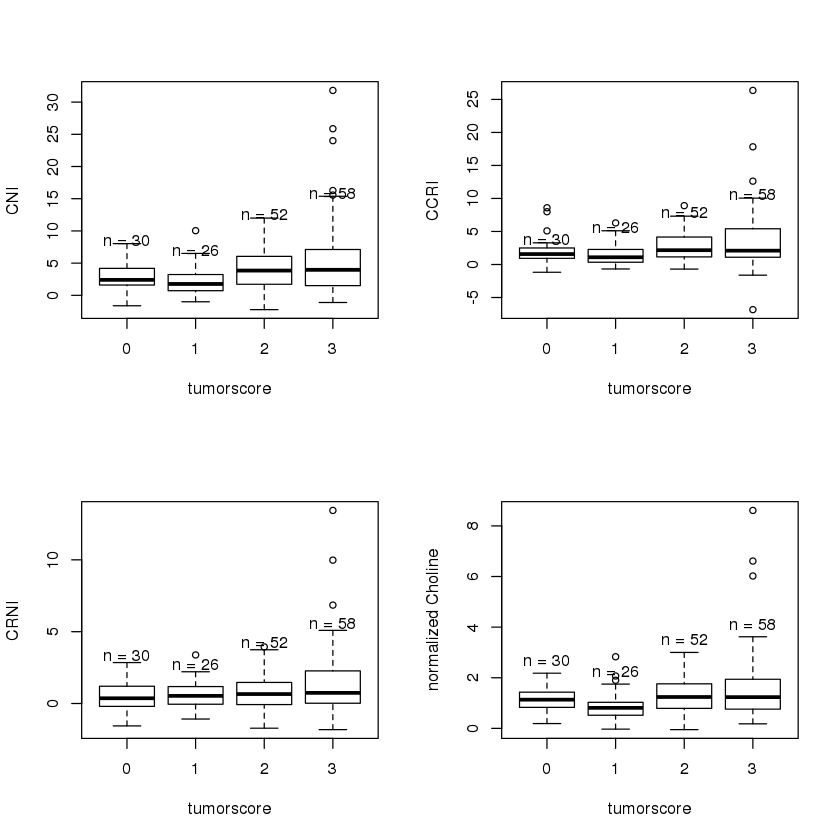

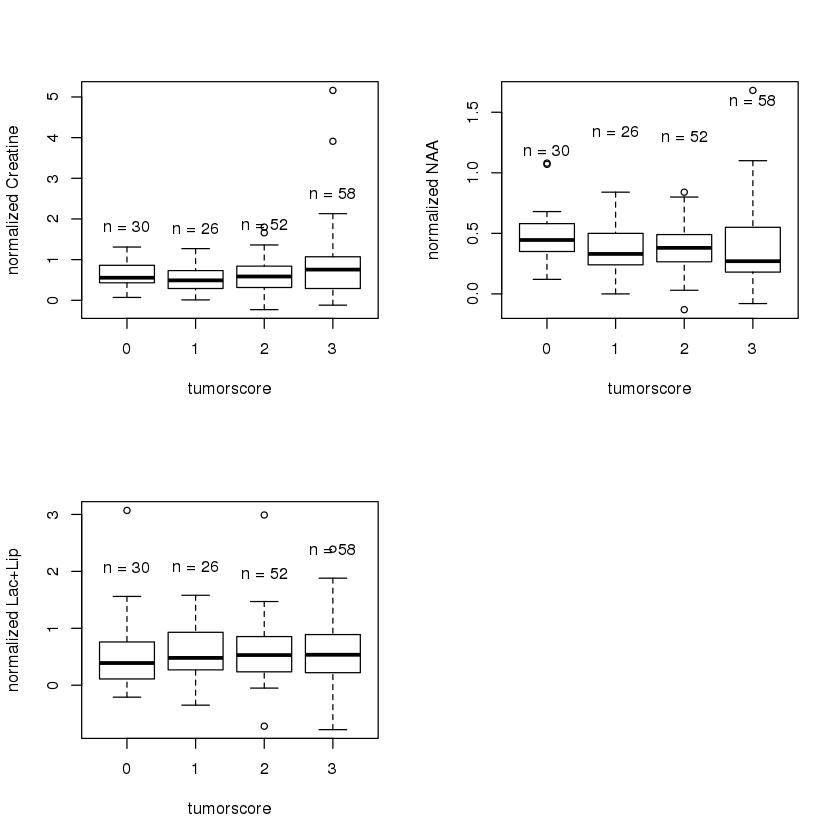

In [9]:
par(mfrow = c(2, 2))
a = boxplot(cni ~ tumor_cell_evaluation , data = recgli, ylab = "CNI", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , a$stats[nrow(a$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

b = boxplot(ccri ~ tumor_cell_evaluation , data = recgli, ylab = "CCRI", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

c = boxplot(crni ~ tumor_cell_evaluation , data = recgli, ylab = "CRNI", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , c$stats[nrow(c$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

d = boxplot(ncho ~ tumor_cell_evaluation , data = recgli, ylab = "normalized Choline", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , d$stats[nrow(d$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

e = boxplot(ncre ~ tumor_cell_evaluation , data = recgli, ylab = "normalized Creatine", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(d$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

f = boxplot(nnaa ~ tumor_cell_evaluation , data = recgli, ylab = "normalized NAA", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(d$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )

g = boxplot(laclip ~ tumor_cell_evaluation , data = recgli, ylab = "normalized Lac+Lip", xlab = "tumorscore")
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , g$stats[nrow(d$stats) , ]+0.5 , paste("n = ",table(recgli$tumor_cell_evaluation),sep="")  )


### b. CEL next to NEL scores  


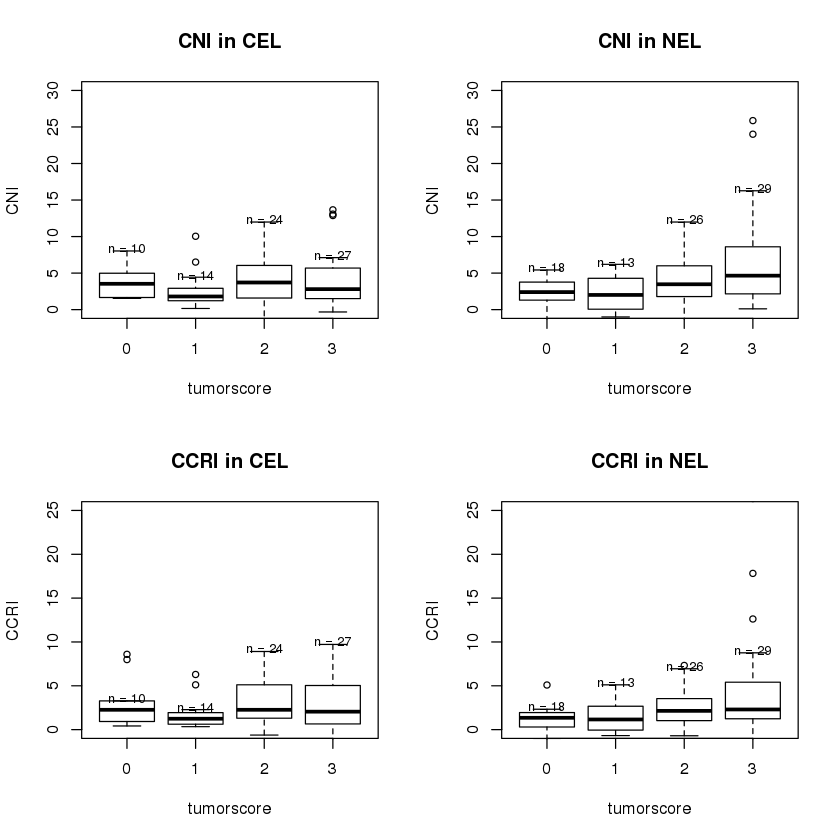

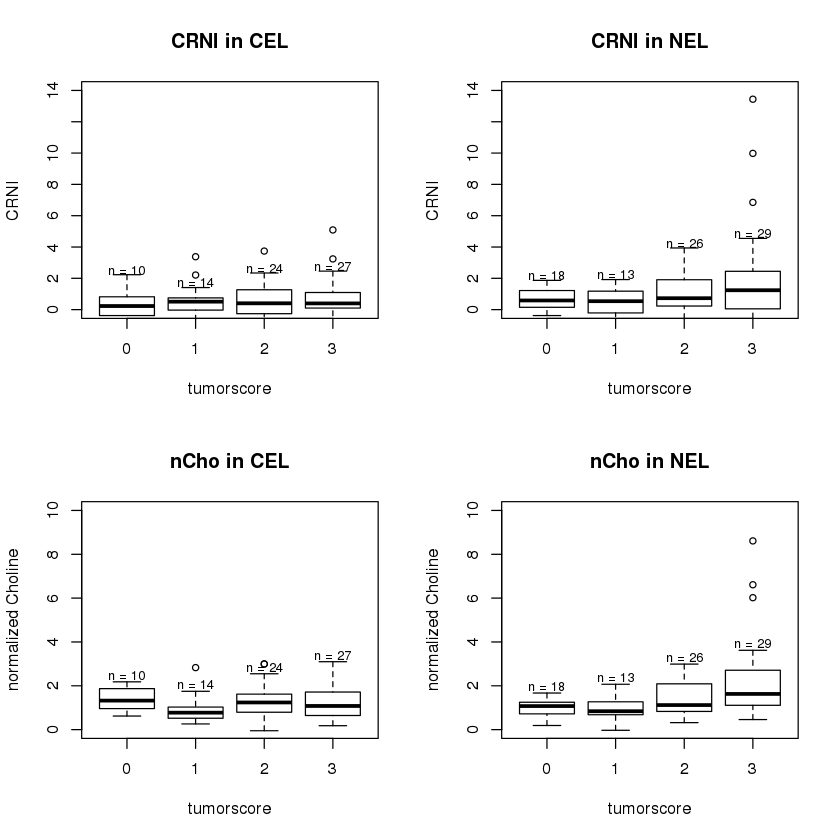

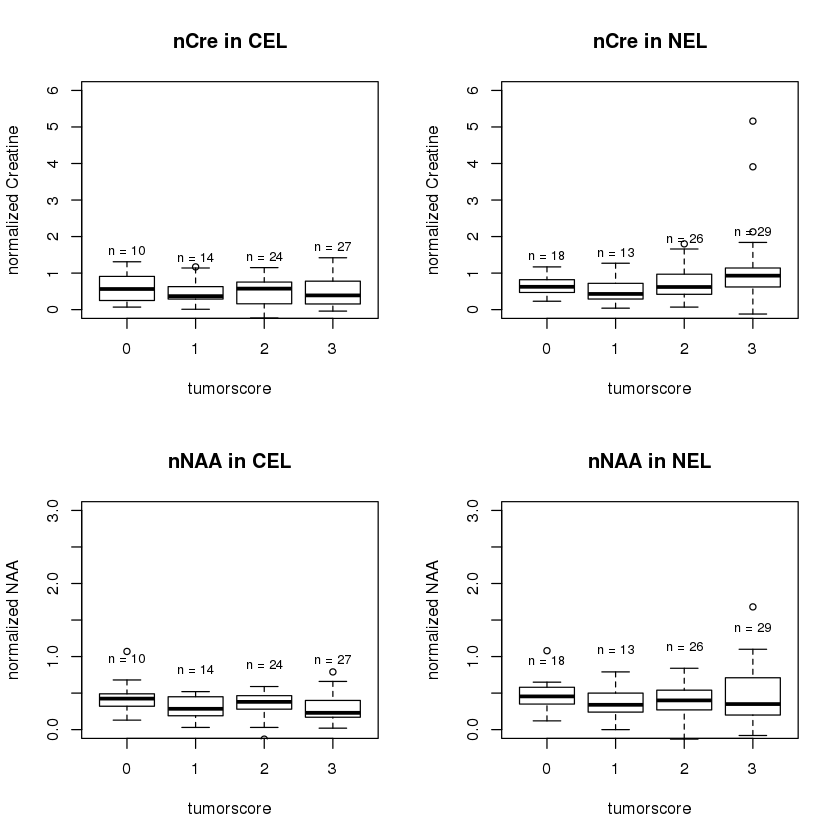

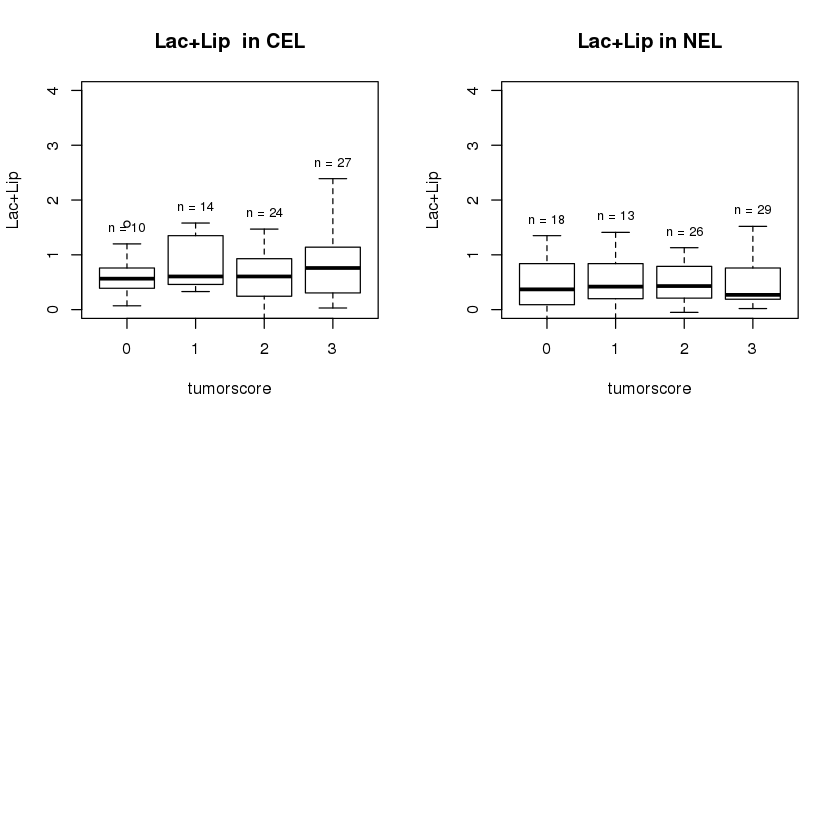

In [10]:
par(mfrow = c(2, 2))
a = boxplot(cni ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "CNI", xlab = "tumorscore", main = "CNI in CEL", ylim = c(0,30))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , a$stats[nrow(a$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_CEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)
b = boxplot(cni ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "CNI", xlab = "tumorscore", main = "CNI in NEL", ylim = c(0,30))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , b$stats[nrow(b$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

c = boxplot(ccri ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "CCRI", xlab = "tumorscore", main = "CCRI in CEL", ylim = c(0,25))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , c$stats[nrow(c$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_CEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)
d = boxplot(ccri ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "CCRI", xlab = "tumorscore", main = "CCRI in NEL", ylim = c(0,25))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , d$stats[nrow(d$stats) , ]+.3 , paste("n = ",table(recgli[which(recgli$in_NEL ==1),]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(crni ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "CRNI", xlab = "tumorscore", main = "CRNI in CEL", ylim = c(0,14))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(crni ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "CRNI", xlab = "tumorscore", main = "CRNI in NEL", ylim = c(0,14))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(ncho ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized Choline", xlab = "tumorscore", main = "nCho in CEL", ylim = c(0,10))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(ncho ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized Choline", xlab = "tumorscore", main = "nCho in NEL", ylim = c(0,10))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(ncre ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized Creatine", xlab = "tumorscore", main = "nCre in CEL", ylim = c(0,6))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(ncre ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized Creatine", xlab = "tumorscore", main = "nCre in NEL", ylim = c(0,6))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(nnaa ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "normalized NAA", xlab = "tumorscore", main = "nNAA in CEL", ylim = c(0,3))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(nnaa ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "normalized NAA", xlab = "tumorscore", main = "nNAA in NEL", ylim = c(0,3))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)

e = boxplot(laclip ~ tumor_cell_evaluation , data = recgli[recgli$in_CEL ==1,], ylab = "Lac+Lip", xlab = "tumorscore", main = "Lac+Lip  in CEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , e$stats[nrow(e$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_CEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)
f = boxplot(laclip ~ tumor_cell_evaluation , data = recgli[recgli$in_NEL ==1,], ylab = "Lac+Lip", xlab = "tumorscore", main = "Lac+Lip in NEL", ylim = c(0,4))
text( c(1:nlevels(factor(recgli$tumor_cell_evaluation))) , f$stats[nrow(f$stats) , ]+.3 , paste("n = ",table(recgli[recgli$in_NEL ==1,]$tumor_cell_evaluation),sep=""), cex = 0.8)


### d. Use GEE to associate perf parameters with TS, no separation


In [11]:
library(glmnet)
library(geepack)
library(lme4)
#install.packages("multgee")
library("multgee")

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: gnm
Loading required package: VGAM
Loading required package: stats4
Loading required package: splines


In [12]:
#cni.fit = ordLORgee(formula = tumor_cell_evaluation ~ cni, link = "logit", 
#                      id = t_number, data = recgli, LORstr = "category.exch", bstart = c(-0.91188, -0.25897, 1, 2.7137))
#summary(cbvn_nlin.fit)$coefficients
## doesn't converge, not enough samples

ERROR: Error in fitLORgee(Y, X_mat, coeffs, ncategories, id, repeated, offset, : Please insert initial values


### e. Use RM ANOVA to try to associate outcome w/ imaging params (not other way around!) 

In [13]:
cni.rmaov = aov(tumor_cell_evaluation ~ cni + Error(t_number/(cni)), data=recgli)
summary(cni.rmaov)

Warning message in aov(tumor_cell_evaluation ~ cni + Error(t_number/(cni)), data = recgli):
“Error() model is singular”


Error: t_number
          Df Sum Sq Mean Sq F value Pr(>F)   
cni        1  16.42  16.422   10.18  0.002 **
Residuals 83 133.85   1.613                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: t_number:cni
          Df Sum Sq Mean Sq F value Pr(>F)
cni        1   0.23  0.2279    0.37  0.546
Residuals 54  33.30  0.6167               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 26  15.47  0.5951               

In [16]:
ccri.rmaov = aov(tumor_cell_evaluation ~ ccri + Error(t_number/(ccri)), data=recgli)
summary(ccri.rmaov)

Warning message in aov(tumor_cell_evaluation ~ ccri + Error(t_number/(ccri)), data = recgli):
“Error() model is singular”


Error: t_number
          Df Sum Sq Mean Sq F value Pr(>F)  
ccri       1  10.44  10.445     6.2 0.0148 *
Residuals 83 139.83   1.685                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: t_number:ccri
          Df Sum Sq Mean Sq F value Pr(>F)
ccri       1   0.17  0.1725   0.297  0.588
Residuals 55  31.94  0.5807               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 25  16.89  0.6756               

In [17]:
crni.rmaov = aov(tumor_cell_evaluation ~ crni + Error(t_number/(crni)), data=recgli)
summary(crni.rmaov)

Warning message in aov(tumor_cell_evaluation ~ crni + Error(t_number/(crni)), data = recgli):
“Error() model is singular”


Error: t_number
          Df Sum Sq Mean Sq F value Pr(>F)  
crni       1  10.91  10.910   6.497 0.0126 *
Residuals 83 139.37   1.679                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: t_number:crni
          Df Sum Sq Mean Sq F value Pr(>F)
crni       1   0.00  0.0003   0.001  0.981
Residuals 54  25.07  0.4642               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 26  23.93  0.9204               

In [18]:
ncho.rmaov = aov(tumor_cell_evaluation ~ ncho + Error(t_number/(ncho)), data=recgli)
summary(ncho.rmaov)

Warning message in aov(tumor_cell_evaluation ~ ncho + Error(t_number/(ncho)), data = recgli):
“Error() model is singular”


Error: t_number
          Df Sum Sq Mean Sq F value Pr(>F)  
ncho       1   11.5  11.503    6.88 0.0104 *
Residuals 83  138.8   1.672                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: t_number:ncho
          Df Sum Sq Mean Sq F value Pr(>F)
ncho       1   0.52  0.5158   0.796  0.376
Residuals 55  35.63  0.6477               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 25  12.86  0.5143               

In [19]:
ncre.rmaov = aov(tumor_cell_evaluation ~ ncre + Error(t_number/(ncre)), data=recgli)
summary(ncre.rmaov)

Warning message in aov(tumor_cell_evaluation ~ ncre + Error(t_number/(ncre)), data = recgli):
“Error() model is singular”


Error: t_number
          Df Sum Sq Mean Sq F value Pr(>F)
ncre       1   4.06   4.063   2.306  0.133
Residuals 83 146.21   1.762               

Error: t_number:ncre
          Df Sum Sq Mean Sq F value Pr(>F)
ncre       1  0.162  0.1619    0.37  0.546
Residuals 55 24.097  0.4381               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 25  24.74  0.9896               

In [20]:
nnaa.rmaov = aov(tumor_cell_evaluation ~ nnaa + Error(t_number/(nnaa)), data=recgli)
summary(nnaa.rmaov)

Warning message in aov(tumor_cell_evaluation ~ nnaa + Error(t_number/(nnaa)), data = recgli):
“Error() model is singular”


Error: t_number
          Df Sum Sq Mean Sq F value Pr(>F)  
nnaa       1   7.08   7.079   4.103  0.046 *
Residuals 83 143.20   1.725                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: t_number:nnaa
          Df Sum Sq Mean Sq F value Pr(>F)
nnaa       1  1.225  1.2247   2.418  0.126
Residuals 54 27.346  0.5064               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 26  20.43  0.7857               

In [ ]:
laclip.rmaov = aov(tumor_cell_evaluation ~ laclip + Error(t_number/(laclip)), data=recgli)
summary(.rmaov)